# <span style="color:darkred"> Laboratorio di Simulazione Numerica </span>
## <span style="color:darkorange">  Esercitazione 10</span>

## 10.1

In questa esercitazione ho adattato l'algoritmo genetico che ho scritto nell'esercitazione $9$ per risolvere il problema del commesso viaggiatore tramite il *Simulated Annealing*. Per comprendere questo procedimento basta fare un parallelismo con la termodinamica, in particolare con il raffreddamento di un liquido. Ad alte temperature le molecole del liquido sono libere di muoversi, ma raffreddando lentamente il sistema perdono mobilità e gli atomi si collocano in modo tale da formare un cristallo ordinato, che è lo stato di minima energia. I sistemi che raffreddano lentamente trovano in modo naturale questo stato di minima energia. Un problema di ottimizzazione può essere quindi incorporato in uno di *annealing*. L'idea è quella di interpretare la funzione costo $L(x)$ come l'energia di un sistema e di considerare la funzione di Boltzmann $p(x) = \frac{exp(-\beta L(x))}{Z}$, in cui $T=1/\beta$ è una temperatura fittizia. Partendo da una configurazione iniziale l'algoritmo compie un numero di step Monte Carlo per ogni valore della temperatura. Il metodo con cui a una specifica temperatura $T$ si campionano nuove configurazione è il Metropolis: avendo un sistema nello stato $x$ con "energia" $L(x)$, si genera un punto $x'$ con $L(x')$ e la nuova configurazione verrà accettata con probabilità $e^{-\beta(L(x')-L(x))}$ se $L(x')>L(x)$, altrimenti con probabilità pari a $1$. Si parte allora con una simulazione ad alta temperatura e si raffredda gradualmente il sistema fino a temperatura nulla. In realtà siccome il tempo di simulazione è finito, otterrò una configurazione vicina al minimo dell'energia, ma non che non è il vero ground state.

Nel mio codice ho implementato il *Simulated Annealing* partendo da una temperatura iniziale $T=25$ e andandola a diminuire di un fattore pari a $1.1$ per un centinaio di cicli. Ad ogni temperatura compio un ciclo di $10^3$ step in cui effettuo le $4$ permutazioni che ho implementato e accetto la nuova configurazione valutando la sua energia come sopra spiegato. Calcolo poi la lunghezza dell'individuo e la salvo su un file. Ho effettuato questa procedura per le città distribuite sia nel quadrato sia sulla circonferenza.

Ho creato un file di *input* in cui il codice legge la temperatura iniziale, il numero di step Monte Carlo per il ciclo sulle mutazioni e il numero di step per il ciclo sulla temperatura. Inoltre ho aggiunto la variabile *forma*, leggendo la quale il codice decide se generare città distribuite su una circonferenza o all'interno del quadrato, e la grandezza $R$, raggio della circonferenza o lato del quadrato.

Ho riportato la lunghezza dell'individuo in funzione degli step sulla temperatura e ho notato che per grandi step ($T$ è decrescente con il numero di step) minimizza il suo valore. Ho riportato anche il percorso dell'ultimo individuo, alla temperatura più bassa che ho simulato.

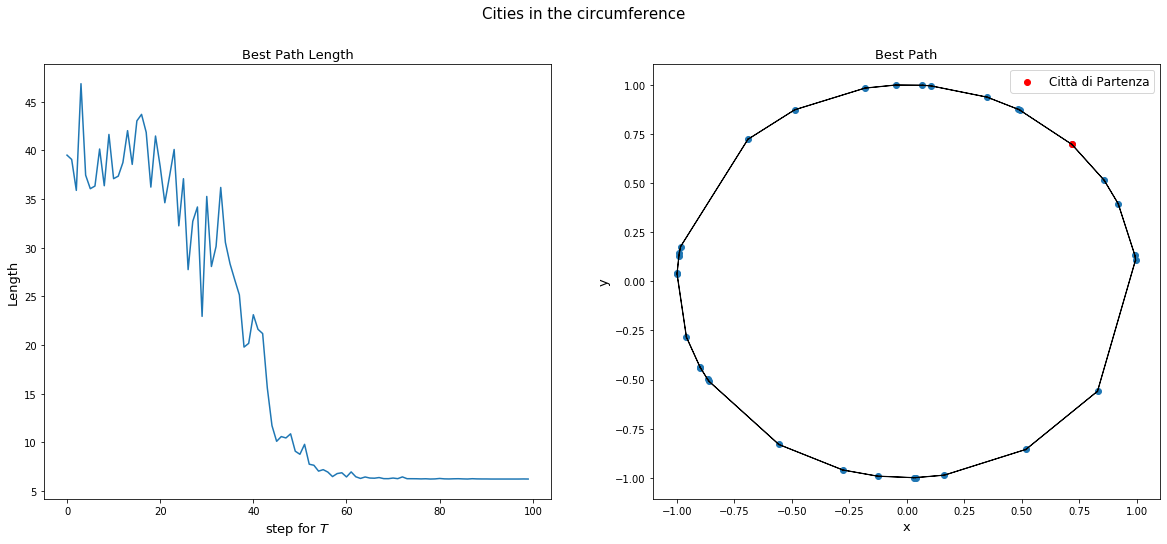

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Cities in the circumference', fontsize=15)
(beta, best_length) = np.loadtxt('10.1/output_cerchio_best_length.dat', usecols=(0,1), unpack = True)
axs[0].plot(beta, best_length)
axs[0].set_title('Best Path Length', fontsize=13)
axs[0].set_xlabel('step for $T$', fontsize=13)
axs[0].set_ylabel('Length', fontsize=13)

(x, y) = np.loadtxt('10.1/output_cerchio_best_path.dat', usecols=(0,1), unpack = True)

for i in range(0, 31):
    axs[1].arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])
    
axs[1].arrow(x[31], y[31], x[0]-x[31], y[0]-y[31])
axs[1].scatter(x, y)    
axs[1].scatter(x[0], y[0], color='red', label="Città di Partenza")
axs[1].legend(fontsize='large')
axs[1].set_title('Best Path', fontsize=13)
axs[1].set_xlabel('x', fontsize=13)
axs[1].set_ylabel('y', fontsize=13)
plt.show()

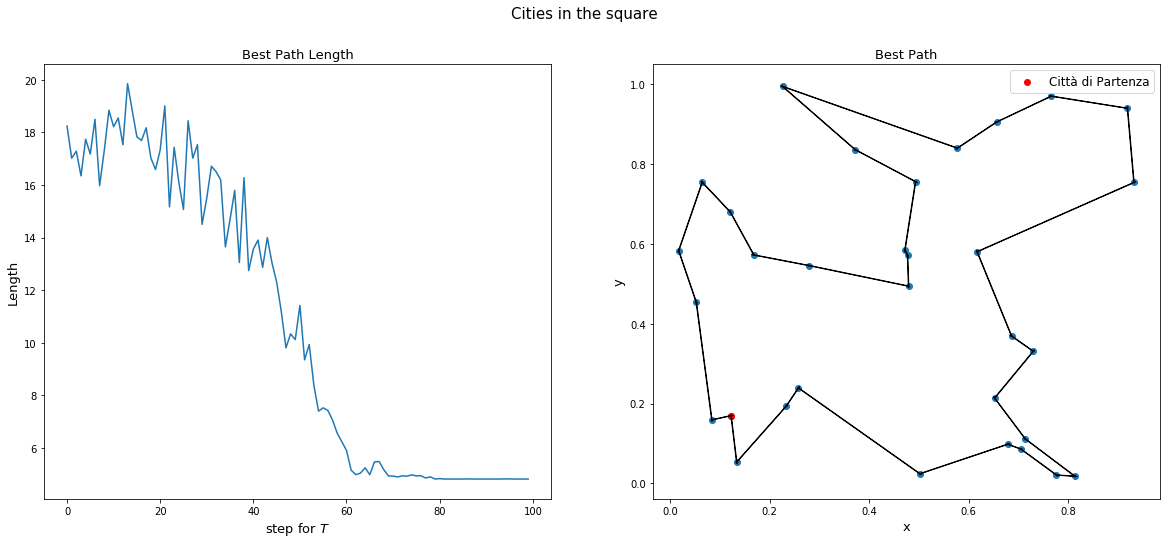

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Cities in the square', fontsize=15)
(beta, best_length) = np.loadtxt('10.1/output_quadrato_best_length.dat', usecols=(0,1), unpack = True)
axs[0].plot(beta, best_length)
axs[0].set_title('Best Path Length', fontsize=13)
axs[0].set_xlabel('step for $T$', fontsize=13)
axs[0].set_ylabel('Length', fontsize=13)

(x, y) = np.loadtxt('10.1/output_quadrato_best_path.dat', usecols=(0,1), unpack = True)

for i in range(0, 31):
    axs[1].arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])
    
axs[1].arrow(x[31], y[31], x[0]-x[31], y[0]-y[31])
axs[1].scatter(x, y)    
axs[1].scatter(x[0], y[0], color='red', label="Città di Partenza")
axs[1].legend(fontsize='large')
axs[1].set_title('Best Path', fontsize=13)
axs[1].set_xlabel('x', fontsize=13)
axs[1].set_ylabel('y', fontsize=13)
plt.show()

## 10.2

Ho parallelizzato con le librerie MPI l'algoritmo genetico affichè la ricerca del minimo della funzione costo fosse effettuata su $4$ nodi differenti. Nel codice ho impostato il generatore di numeri casuali in modo che ogni nodo leggesse una riga differente del file *Primes*, che caratterizza il seme del generatore. Questo mi permette di esplorare regioni diverse dello spazio delle configurazioni e quindi dà più possibilità di trovare l'energia minima.
Ho generato le città solo all'interno del quadrato e affinchè fossero generate uguali in ogni nodo ho deciso di usare il generatore random del nodo $0$ e poi di distribuirle a tutti gli altri tramite una funzione di MPI che si chiama *MPI_Bcast*. Così ogni nodo ha lo stesso set di $N=32$ città iniziali con le quali comincia l'algoritmo genetico, che lavora nello stesso modo che ho descritto nell'esercitazione $9$. L'unica differenza è che ogni $N_{migr}=30$ i nodi si scambiano il migliore individuo della propria popolazione. Ho utilizzato per questo le funzioni *MPI_Send* ed *MPI_Recv*, con cui due nodi si mandano e ricevono variabili. Ho implementato la migrazione generando come prima cosa in un nodo due interi casuali nell'intervallo $[0, 3]$ e tramite *MPI_Bcast* li ho trasmessi agli altri nodi. Questi due interi sono i nodi selezionati per scambiarsi il loro migliore individuo. Le funzioni *MPI_Send* ed *MPI_Recv* scambiano facilmente vettori e siccome gli individui che ho implementato nelle popolazioni del mio algoritmo genetico sono classi, ho fatto salvare i loro geni all'interno di due *vector*. Ponendomi prima in un nodo e poi nell'altro ho poi implementato *MPI_Send* ed *MPI_Recv* affinchè mandassero il loro migliore e ricevessero quello dell'altro nodo, sostituendolo all'interno della popolazione. Ho ordinato la popolazione e stampato per ogni nodo il migliore della generazione. Ho eseguito l'algoritmo per $3000$ generazioni, analogamente a quanto fatto per l'esercitazione $9$ al fine di paragonarle. Il minimo raggiunto dall'algoritmo parallelo è più basso di quello raggiunto con un solo nodo. Risulta quindi efficiente lavorare su nodi paralleli per esplorare configurazioni diverse e quindi non rimanere in minimi locali.

Ho riportato le lunghezze dei percorsi migliori in funzione delle generazioni e il percorso migliore dell'ultima generazione. Ho notato che nel caso parallelo tutti i nodi hanno raggiunto lo stesso minimo, tuttavia le curve in cui si osserva la minimizzazione della lunghezza sono diverse, indice del fatto che hanno esplorato regioni differenti.
Ho riportato anche il confronto con l'algoritmo non parallelo implementato nella nona esercitazione.

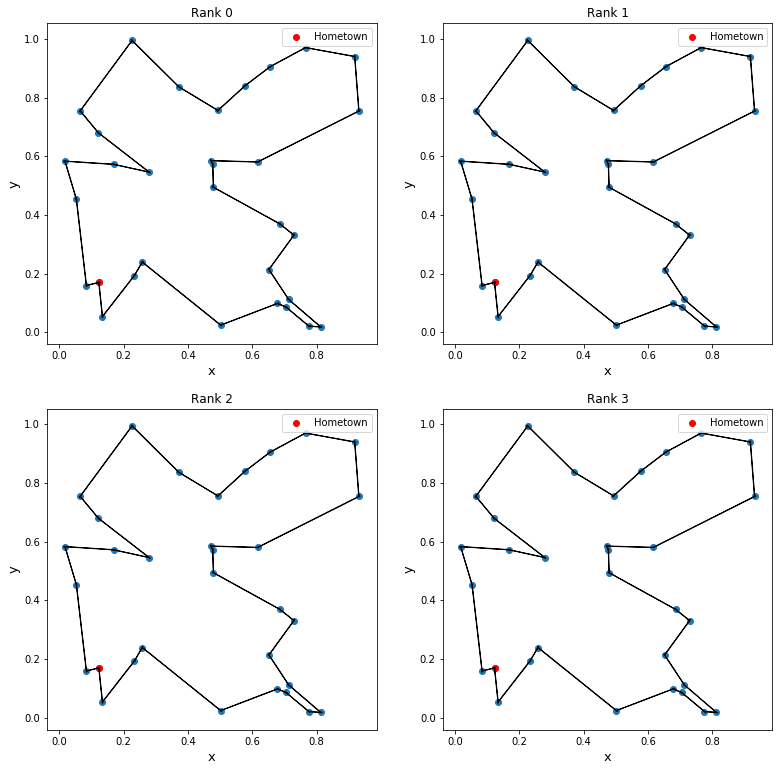

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(13,13))

# ----- Rank 0 ----
(x, y) = np.loadtxt('10.2/output_best_path_rank0.dat', usecols=(0,1), unpack = True)
axs[0, 0].set_title('Rank 0')
for i in range(0, 31):
    axs[0, 0].arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])
axs[0, 0].arrow(x[31], y[31], x[0]-x[31], y[0]-y[31])
axs[0, 0].scatter(x, y)    
axs[0, 0].scatter(x[0], y[0], color='red', label="Hometown")

# ----- Rank 1 ----
(x, y) = np.loadtxt('10.2/output_best_path_rank1.dat', usecols=(0,1), unpack = True)
axs[0, 1].set_title('Rank 1')
for i in range(0, 31):
    axs[0, 1].arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])
axs[0, 1].arrow(x[31], y[31], x[0]-x[31], y[0]-y[31])
axs[0, 1].scatter(x, y)    
axs[0, 1].scatter(x[0], y[0], color='red', label="Hometown")

# ----- Rank 2 ----
(x, y) = np.loadtxt('10.2/output_best_path_rank2.dat', usecols=(0,1), unpack = True)
axs[1, 0].set_title('Rank 2')
for i in range(0, 31):
    axs[1, 0].arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])
axs[1, 0].arrow(x[31], y[31], x[0]-x[31], y[0]-y[31])
axs[1, 0].scatter(x, y)    
axs[1, 0].scatter(x[0], y[0], color='red', label="Hometown")

# ----- Rank 3 ----
(x, y) = np.loadtxt('10.2/output_best_path_rank3.dat', usecols=(0,1), unpack = True)
axs[1, 1].set_title('Rank 3')
for i in range(0, 31):
    axs[1, 1].arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])
axs[1, 1].arrow(x[31], y[31], x[0]-x[31], y[0]-y[31])
axs[1, 1].scatter(x, y)    
axs[1, 1].scatter(x[0], y[0], color='red', label="Hometown")

for ax in axs.flat:
    ax.legend()
    ax.set_xlabel('x', fontsize=13)
    ax.set_ylabel('y', fontsize=13)

plt.show()

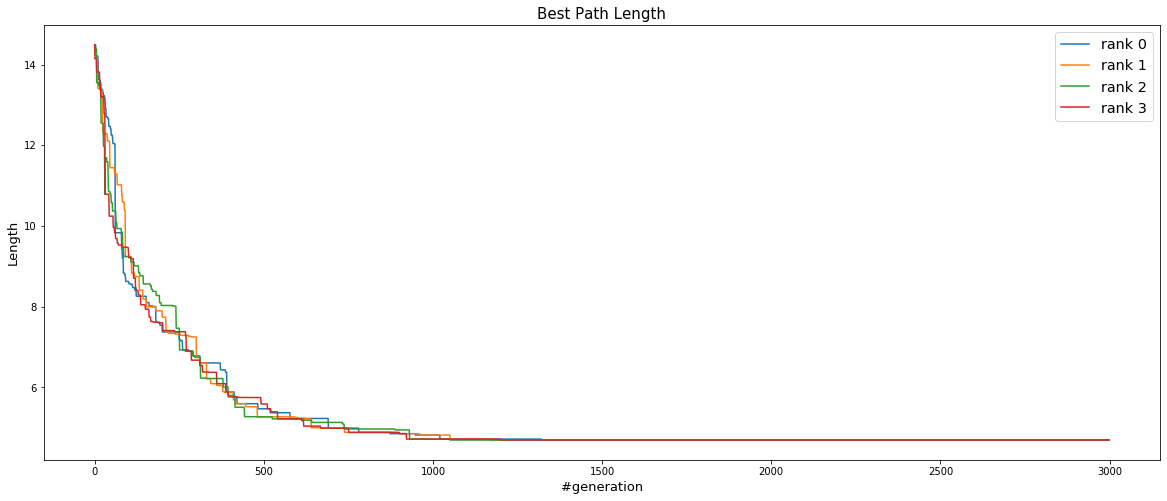

In [4]:
plt.figure(figsize=(20, 8))
# ----- Rank 0 ---- 
(gen, length1) = np.loadtxt('10.2/output_best_length_rank0.dat', usecols=(0,1), unpack = True)
plt.plot(gen, length1, label='rank 0')
# ----- Rank 1 ----
(gen, length2) = np.loadtxt('10.2/output_best_length_rank1.dat', usecols=(0,1), unpack = True)
plt.plot(gen, length2, label='rank 1')
# ----- Rank 2 ----
(gen, length3) = np.loadtxt('10.2/output_best_length_rank2.dat', usecols=(0,1), unpack = True)
plt.plot(gen, length3, label='rank 2')
# ----- Rank 3 ----
(gen, length4) = np.loadtxt('10.2/output_best_length_rank3.dat', usecols=(0,1), unpack = True)
plt.plot(gen, length4, label='rank 3')

plt.xlabel('#generation', fontsize=13)
plt.ylabel('Length', fontsize=13)
plt.title('Best Path Length', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

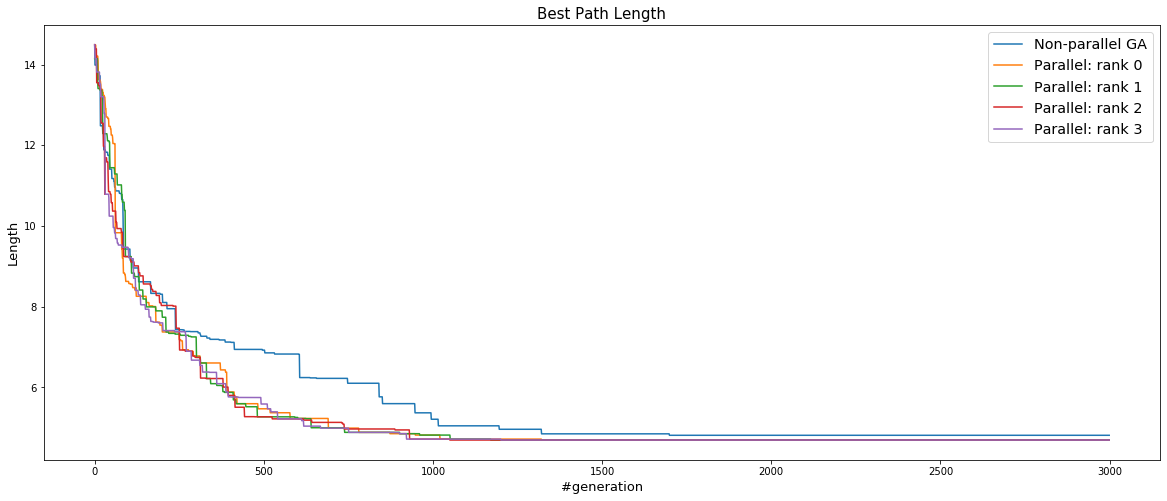

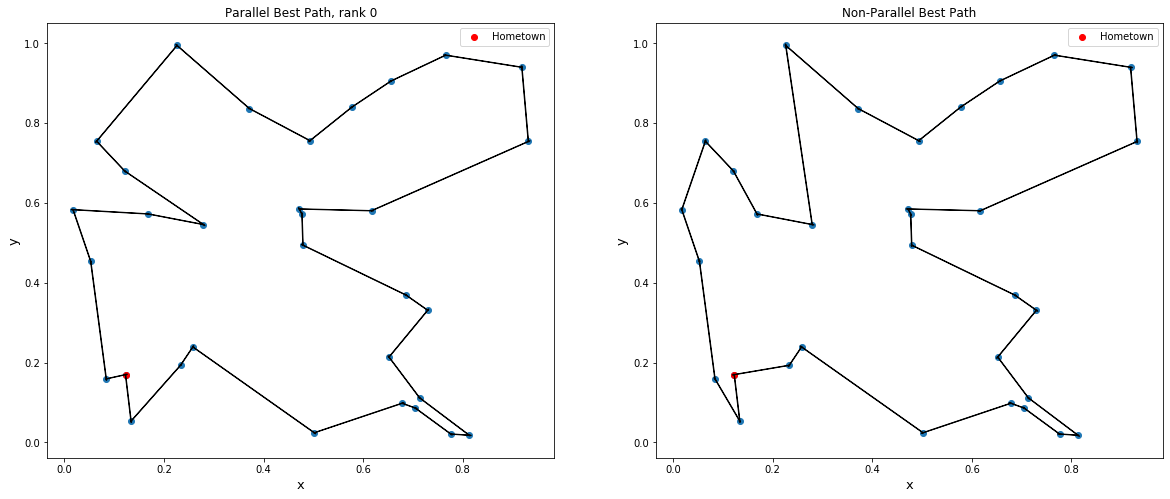

In [5]:
plt.figure(figsize=(20, 8))
#length5 è quella dell'esercizio 9
(gen, length5) = np.loadtxt('../Exercise09/output_quadrato_best_length.dat', usecols=(0,1), unpack = True)

plt.plot(gen, length5, label='Non-parallel GA')
plt.plot(gen, length1, label='Parallel: rank 0')
plt.plot(gen, length2, label='Parallel: rank 1')
plt.plot(gen, length3, label='Parallel: rank 2')
plt.plot(gen, length4, label='Parallel: rank 3')

plt.xlabel('#generation', fontsize=13)
plt.ylabel('Length', fontsize=13)
plt.title('Best Path Length', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20,8))
# ----- Rank 0 ----
(x, y) = np.loadtxt('10.2/output_best_path_rank0.dat', usecols=(0,1), unpack = True)
axs[0].set_title("Parallel Best Path, rank 0")
for i in range(0, 31):
    axs[0].arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])    
axs[0].arrow(x[31], y[31], x[0]-x[31], y[0]-y[31])
axs[0].scatter(x, y)    
axs[0].scatter(x[0], y[0], color='red', label="Hometown")
# ----Esercizio 9----
(x, y) = np.loadtxt('../Exercise09/output_quadrato_best_path.dat', usecols=(0,1), unpack = True)
axs[1].set_title('Non-Parallel Best Path')
for i in range(0, 31):
    axs[1].arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])   
axs[1].arrow(x[31], y[31], x[0]-x[31], y[0]-y[31])
axs[1].scatter(x, y)    
axs[1].scatter(x[0], y[0], color='red', label="Hometown")

for ax in axs.flat:
    ax.legend()
    ax.set_xlabel('x', fontsize=13)
    ax.set_ylabel('y', fontsize=13)
    
plt.show()